In [1]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
from entornos import *
from agentes import *
from busqueda import *
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
gum.config['notebook','potential_visible_digits']=2
import warnings
warnings.filterwarnings('ignore')

** pyAgrum** For better visualizations, please install matplotlib-inline.
** pyAgrum** For better visualizations, please install matplotlib-inline.


In [36]:
import pyAgrum as gum
import pyAgrum.lib.image as gumimage

In [2]:
def maximo_aleatorio(valores):
    indices = [i for i, x in enumerate(valores) if x == max(valores)]
    return np.random.choice(indices)

W = Wumpus()
def adyacentes(c):
    return W.adyacentes(c)

def pozos_a_brisa(d):
    if 1 not in d.values():
        return [1,0]
    else:
        return [0,1]

def oro_a_brillo(c1,c2):
    if c1 == c2:
        return [0,1]
    else:
        return [1,0]
    
    
def tomar_decision(casilla, evs, tabla=False, imagen=False):
    # Creamos la red de decision para la casilla dada
    model = crear_red_decision(casilla)
    # Guardamos solo la evidencia que cae en las variables de la red de decisión
    evid = {v:evs[v] for v in evs.keys() if v in model.names()}
    # Hacemos la inferencia
    ie = gum.InfluenceDiagramInference(model)
    ie.setEvidence(evid)
    ie.makeInference()
    casillas = [c for c in adyacentes(casilla)]
    valores = ie.posteriorUtility("Casilla")
    if tabla:
        print(valores)
    # Escogemos la acción con mayor utilidad esperada
    decision = maximo_aleatorio(valores.tolist())
    if tabla:
        print('Decisión ->', casillas[decision])
    if imagen:
        gnb.showInference(model,evs=evid,targets={},size="30")
    return casillas[decision]


def programa_utility_based(self, DEB=False):
       
    # Encuentra la casilla actual
    casilla_actual = self.loc
#    print('agente en:', casilla_actual, self.oro)
    direccion = self.direccion
    percepcion = self.perceptos
    casillas_seguras = self.seguras
    evidencia = self.evidencia
    oro = self.oro
    
    # Si tiene el oro y está en la casilla de salida, salir
    if oro and (casilla_actual == (0,0)):
        self.acciones = ['salir']
    # Si ve el oro, lo toma y planea un camino hasta la salida
    if 'brillo' in percepcion:
#        print("¡Veo el oro!")
        self.oro = True
        self.acciones = ['agarrar']
        R = Rejilla(casilla_actual, (0,0), casillas_seguras)
        camino = best_first_search(R)
        camino = [casilla_actual] + solucion(camino)
        acs = acciones_camino(camino, direccion)
        if DEB:
            print(f'desde {casilla_actual} hasta {casilla_ir}')
            print(f'sigue el camino {acs}')
        self.acciones += acs
    else:
        # Escoje la casilla de mayor utilidad
        casilla_ir = tomar_decision(casilla_actual, evidencia, tabla=DEB)
        camino = [casilla_actual, casilla_ir]
        acs = acciones_camino(camino, direccion)
        if DEB:
            print(f'desde {casilla_actual} hasta {casilla_ir}')
            print(f'sigue el camino {acs}')
        self.acciones += acs

setattr(Agente, "programa", programa_utility_based)

In [41]:

def utilidad(d):
    C = d['Casilla']
    if (d['pozo'+C] == 0) and (d['oro'] == C):
        return 1
    elif (d['pozo'+C] == 0):
        return 0
    else:
        return -1
    
def crear_red_decision(cas):   
    
    model = gum.InfluenceDiagram()
    
    todas_casillas = [(x,y) for x in range(4) for y in range(4)]
    total_casillas = len(todas_casillas)
    casillas = adyacentes(cas)
    num_casillas = len(casillas)
    aux = [adyacentes(c) for c in casillas]
    aux = [item for sublist in aux for item in sublist]
    casillas_adyacentes2 = list(set(aux))
    aux = [adyacentes(c) for c in casillas_adyacentes2]
    aux = [item for sublist in aux for item in sublist]
    casillas_adyacentes3 = list(set(aux))

    # Creando variables del oro y brillo
    oro = gum.LabelizedVariable('oro','oro',total_casillas)
    for i, c in enumerate(todas_casillas):
        oro.changeLabel(i,str(c))
        brillo_i = gum.LabelizedVariable('brillo'+str(c),'brillo'+str(c),2)
        model.addChanceNode(brillo_i)
    model.addChanceNode(oro)

    # Creando variables de pozo
    for c in casillas_adyacentes3:
        pozo_i = gum.LabelizedVariable('pozo'+str(c),'pozo'+str(c),2)
        model.addChanceNode(pozo_i)

    # Creando variables de brisa
    for c1 in casillas_adyacentes2:
        brisa_i = gum.LabelizedVariable('brisa'+str(c1),'brisa'+str(c1),2)
        model.addChanceNode(brisa_i)

    # Creando variables de casilla
    casilla = gum.LabelizedVariable('Casilla','Casilla a moverse',num_casillas)
    for i, c in enumerate(casillas):
        casilla.changeLabel(i,str(c))
    model.addDecisionNode(casilla)

    # Creando variable de utilidad
    ut_casilla = gum.LabelizedVariable('UtilityOfCasilla','Valor casilla',1)
    model.addUtilityNode(ut_casilla)

    # Creando aristas del grafo
    for c in todas_casillas:
        model.addArc('oro', 'brillo'+str(c))
    for c in casillas_adyacentes3:
        for c1 in adyacentes(c):
            if c1 in casillas_adyacentes2:
                model.addArc('pozo'+str(c), 'brisa'+str(c1))
    for c in casillas:
        model.addArc('pozo'+str(c), 'UtilityOfCasilla')
    model.addArc('oro', 'UtilityOfCasilla')
    model.addArc('Casilla', 'UtilityOfCasilla')
    
    # Creando tablas de probabilidad
    model.cpt('oro').fillWith([1/total_casillas]*total_casillas)
    for c in todas_casillas:
        brillo = 'brillo' + str(c)
        for c1 in todas_casillas:
            model.cpt(brillo)[{'oro': str(c1)}] = oro_a_brillo(c,c1)
    
    pozos = ['pozo'+str(c) for c in casillas_adyacentes3]
    for pozo in pozos:
        model.cpt(pozo)[:]=[0.8,0.2]

    for c in casillas_adyacentes2:
        brisa = 'brisa' + str(c)
        pozos_brisa = ['pozo'+str(c1) for c1 in adyacentes(c)]
        opciones = list(product(*[[0,1] for p in pozos_brisa]))
        dicts_variables = [{pozos_brisa[i]:op[i] for i in range(len(pozos_brisa))} for op in opciones]
        for d in dicts_variables:
            model.cpt(brisa)[d] = pozos_a_brisa(d)
        
    # Creando la utilidad
    pozos = ['pozo'+str(c) for c in casillas]
    casillas = [str(c) for c in adyacentes(cas)]
    todas_casillas = [str(c) for c in todas_casillas]
    variables = ['Casilla','oro'] + pozos
    opciones = list(product(casillas, todas_casillas, *[[0,1] for i in pozos]))
    dicts_variables = [{variables[i]:op[i] for i in range(len(variables))} for op in opciones]
    for d in dicts_variables:
        model.utility('UtilityOfCasilla')[d]=utilidad(d)

    return model

In [44]:
def wumpus_a_hedor(c,c1):
    if c1 not in adyacentes(c):
        return [1,0]
    else:
        return [0,1]
    
def utilidad(d):
    C = d['Casilla']
    if (d['pozo'+C] == 0) and (d['oro'] == C) and (d['Wumpus'] != C):
        return 1
    elif (d['pozo'+C] == 0) and (d['Wumpus'] != C):
        return 0
    else:
        return -1

def crear_red_decision(cas):   
    
    model = gum.InfluenceDiagram()
    
    todas_casillas = [(x,y) for x in range(4) for y in range(4)]
    total_casillas = len(todas_casillas)
    casillas = adyacentes(cas)
    num_casillas = len(casillas)
    aux = [adyacentes(c) for c in casillas]
    aux = [item for sublist in aux for item in sublist]
    casillas_adyacentes2 = list(set(aux))
    aux = [adyacentes(c) for c in casillas_adyacentes2]
    aux = [item for sublist in aux for item in sublist]
    casillas_adyacentes3 = list(set(aux))

    # Creando variables del oro y brillo
    oro = gum.LabelizedVariable('oro','oro',total_casillas)
    for i, c in enumerate(todas_casillas):
        oro.changeLabel(i,str(c))
        brillo_i = gum.LabelizedVariable('brillo'+str(c),'brillo'+str(c),2)
        model.addChanceNode(brillo_i)
    model.addChanceNode(oro)

    # Creando variables de pozo
    for c in casillas_adyacentes3:
        pozo_i = gum.LabelizedVariable('pozo'+str(c),'pozo'+str(c),2)
        model.addChanceNode(pozo_i)

    # Creando variables de brisa
    for c1 in casillas_adyacentes2:
        brisa_i = gum.LabelizedVariable('brisa'+str(c1),'brisa'+str(c1),2)
        model.addChanceNode(brisa_i)

    # Creando variables de casilla
    casilla = gum.LabelizedVariable('Casilla','Casilla a moverse',num_casillas)
    for i, c in enumerate(casillas):
        casilla.changeLabel(i,str(c))
    model.addDecisionNode(casilla)

    # Creando variable de utilidad
    ut_casilla = gum.LabelizedVariable('UtilityOfCasilla','Valor casilla',1)
    model.addUtilityNode(ut_casilla)
    
    #Creando variable Wumpus y hedor
    Wumpus = gum.LabelizedVariable('Wumpus','Wumpus',total_casillas)
    for i, c in enumerate(todas_casillas):
        Wumpus.changeLabel(i,str(c))
        hedor_i = gum.LabelizedVariable('hedor'+str(c),'hedor'+str(c),2)
        model.addChanceNode(hedor_i)
    model.addChanceNode(Wumpus)
    

    # Creando aristas del grafo
    for c in todas_casillas:
        model.addArc('oro', 'brillo'+str(c))
        model.addArc('Wumpus', 'hedor'+str(c))
    for c in casillas_adyacentes3:
        for c1 in adyacentes(c):
            if c1 in casillas_adyacentes2:
                model.addArc('pozo'+str(c), 'brisa'+str(c1))         
    for c in casillas:
        model.addArc('pozo'+str(c), 'UtilityOfCasilla')
    model.addArc('oro', 'UtilityOfCasilla')
    model.addArc('Casilla', 'UtilityOfCasilla')
    model.addArc('Wumpus', 'UtilityOfCasilla')
    
    # Creando tablas de probabilidad
    model.cpt('oro').fillWith([1/total_casillas]*total_casillas)
    model.cpt('Wumpus').fillWith([1/total_casillas-1]*total_casillas)
    
    for c in todas_casillas:
        brillo = 'brillo' + str(c)
        for c1 in todas_casillas:
            model.cpt(brillo)[{'oro': str(c1)}] = oro_a_brillo(c,c1)
    
    pozos = ['pozo'+str(c) for c in casillas_adyacentes3]
    for pozo in pozos:
        model.cpt(pozo)[:]=[0.8,0.2]

    for c in todas_casillas:
        hedor = 'hedor' + str(c)
        for i, c1 in enumerate(todas_casillas):
            model.cpt(hedor)[{'Wumpus': str(c1)}] = wumpus_a_hedor(c,c1)
        
    # Creando la utilidad
    pozos = ['pozo'+str(c) for c in casillas]
    casillas = [str(c) for c in adyacentes(cas)]
    todas_casillas = [str(c) for c in todas_casillas]
    variables = ['Casilla','oro','Wumpus'] + pozos 
    opciones = list(product(casillas, todas_casillas,todas_casillas, *[[0,1] for i in pozos]))
    dicts_variables = [{variables[i]:op[i] for i in range(len(variables))} for op in opciones]
    for d in dicts_variables:
        model.utility('UtilityOfCasilla')[d]=utilidad(d)

    return model

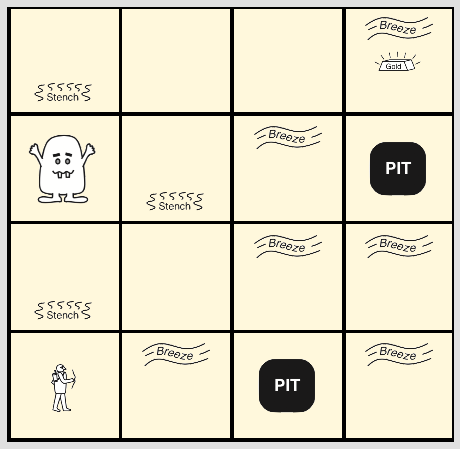

{'pozo(0, 0)': 0, 'brillo(0, 0)': 0, 'brisa(0, 0)': 0, 'hedor(0, 0)': 0}


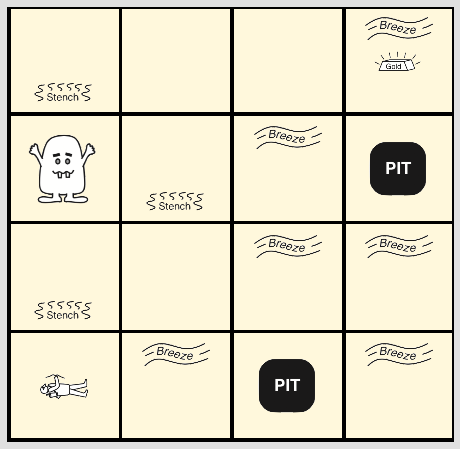

{'pozo(0, 0)': 0, 'brillo(0, 0)': 0, 'brisa(0, 0)': 0, 'hedor(0, 0)': 0}


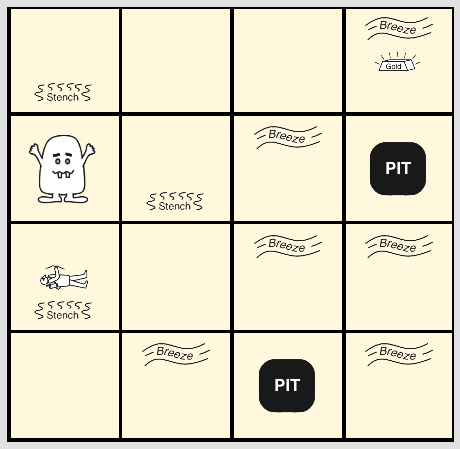

In [45]:
W = Wumpus(wumpus=(0,2), oro=(3,3), pozos=[(2,0), (3,2)])
agente = Agente()
evidencia = {'pozo(0, 0)':0}
casillas_seguras = []
setattr(Agente, "evidencia", evidencia)
setattr(Agente, "seguras", casillas_seguras)
formulas = agente.fluentes_mapa_mental()
formulas += [f'en(0,0)_1', 'mirando_e_1', 'segura(0,0)']
agente.base = LPQuery(formulas)
agente.perceptos = W.para_sentidos()
c = agente.interp_percepto(mundo='wumpus')
agente.base.TELL(c)
max_turnos = 5
W.pintar_todo()
plt.show()


acciones = ['voltearIzquierda', 'adelante']
agente.acciones = acciones

for t in range(len(acciones)):
#    vis(agente)
    casilla_actual = agente.loc
    if casilla_actual not in casillas_seguras:
        casillas_seguras.append(agente.loc)
    agente.perceptos = W.para_sentidos()
    if 'brillo' not in agente.perceptos:
        agente.evidencia['brillo'+str(casilla_actual)] = 0
    if 'brisa' in agente.perceptos:
        agente.evidencia['brisa'+str(casilla_actual)] = 1
    else:
        agente.evidencia['brisa'+str(casilla_actual)] = 0 
        
    if 'hedor' in agente.perceptos:
        agente.evidencia['hedor'+str(casilla_actual)] = 1
    else:
        agente.evidencia['hedor'+str(casilla_actual)] = 0
    print(agente.evidencia)
    a = agente.reaccionar(DEB=True)
#    print(a)
    formula_accion = f'{a}_{agente.turno-1}'
    agente.base.TELL(formula_accion)
    W.transicion(a)
#    if not W.juego_activo:
#        clear_output(wait=True)
#        print(W.mensaje)
#        break
#    clear_output(wait=True)
    agente.estimar_estado(W)
    W.pintar_todo()
    plt.show()
    sleep(.5) 
casilla_actual = agente.loc
if casilla_actual not in casillas_seguras:
    casillas_seguras.append(agente.loc)
agente.perceptos = W.para_sentidos()
if 'brillo' not in agente.perceptos:
    agente.evidencia['brillo'+str(casilla_actual)] = 0
if 'brisa' in agente.perceptos:
    agente.evidencia['brisa'+str(casilla_actual)] = 1
else:
    agente.evidencia['brisa'+str(casilla_actual)] = 0 

if 'hedor' in agente.perceptos:
    agente.evidencia['hedor'+str(casilla_actual)] = 1
else:
    agente.evidencia['hedor'+str(casilla_actual)] = 0

In [46]:
agente.evidencia

{'pozo(0, 0)': 0,
 'brillo(0, 0)': 0,
 'brisa(0, 0)': 0,
 'hedor(0, 0)': 0,
 'brillo(0, 1)': 0,
 'brisa(0, 1)': 0,
 'hedor(0, 1)': 1}

In [47]:
model = crear_red_decision((0,1))
evid = {v:agente.evidencia[v] for v in agente.evidencia.keys() if v in model.names()}
tomar_decision((0,1),evid,tabla=True)


  Casilla                    |
(1, 1)   |(0, 0)   |(0, 2)   |
---------|---------|---------|
 0.0000  | 0.0000  | 0.0000  |

Decisión -> (0, 2)


(0, 2)

In [26]:
d = {'Casilla': '(1, 1)', 'oro': '(1, 1)', 'Wumpus': '(0, 0)', 'pozo(1, 1)': 1, 'pozo(0, 0)': 0, 'pozo(0, 2)': 0}
utilidad(d)

-1

In [40]:
gumimage.export(model,"test_export.pdf")

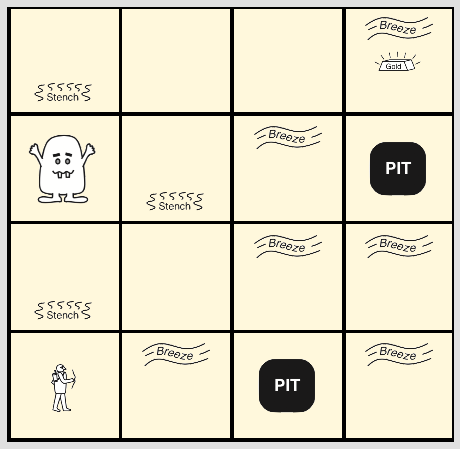

{'pozo(0, 0)': 0, 'brillo(0, 0)': 0, 'brisa(0, 0)': 0, 'hedor(0, 0)': 0}

  Casilla          |
(1, 0)   |(0, 1)   |
---------|---------|
 0.0000  | 0.0000  |

Decisión -> (0, 1)
desde (0, 0) hasta (0, 1)
sigue el camino ['voltearIzquierda', 'adelante']


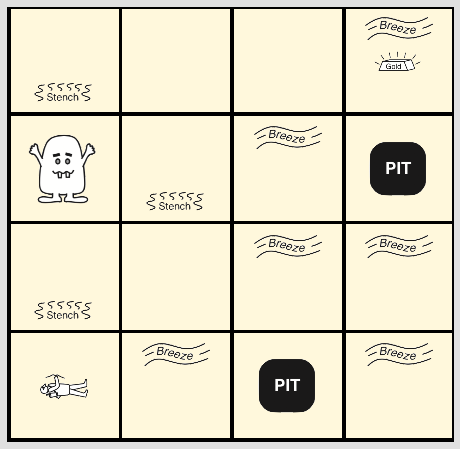

{'pozo(0, 0)': 0, 'brillo(0, 0)': 0, 'brisa(0, 0)': 0, 'hedor(0, 0)': 0}


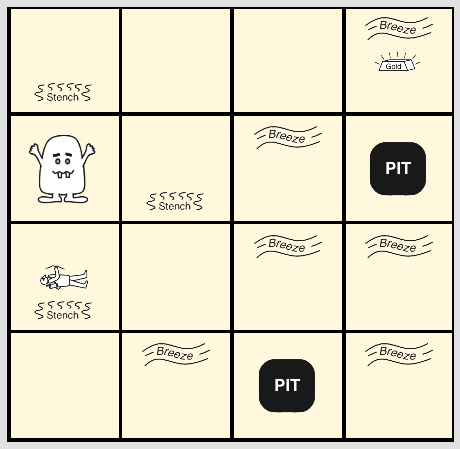

In [31]:
from time import sleep
from IPython.display import clear_output

W = Wumpus(wumpus=(0,2), oro=(3,3), pozos=[(2,0), (3,2)])
agente = Agente()
evidencia = {'pozo(0, 0)':0}
casillas_seguras = []
setattr(Agente, "evidencia", evidencia)
setattr(Agente, "seguras", casillas_seguras)
formulas = agente.fluentes_mapa_mental()
formulas += [f'en(0,0)_1', 'mirando_e_1', 'segura(0,0)']
agente.base = LPQuery(formulas)
agente.perceptos = W.para_sentidos()
c = agente.interp_percepto(mundo='wumpus')
agente.base.TELL(c)
max_turnos = 2
W.pintar_todo()
plt.show()

for t in range(max_turnos):
#    vis(agente)
    casilla_actual = agente.loc
    if casilla_actual not in casillas_seguras:
        casillas_seguras.append(agente.loc)
    agente.perceptos = W.para_sentidos()
    if 'brillo' not in agente.perceptos:
        agente.evidencia['brillo'+str(casilla_actual)] = 0
    if 'brisa' in agente.perceptos:
        agente.evidencia['brisa'+str(casilla_actual)] = 1
    else:
        agente.evidencia['brisa'+str(casilla_actual)] = 0 
        
    if 'hedor' in agente.perceptos:
        agente.evidencia['hedor'+str(casilla_actual)] = 1
    else:
        agente.evidencia['hedor'+str(casilla_actual)] = 0
    
        
    print(agente.evidencia)
    a = agente.reaccionar(DEB=True)
#    print(a)
    formula_accion = f'{a}_{agente.turno-1}'
    agente.base.TELL(formula_accion)
    W.transicion(a)
#    if not W.juego_activo:
#        clear_output(wait=True)
#        print(W.mensaje)
#        break
#    clear_output(wait=True)
    agente.estimar_estado(W)
    W.pintar_todo()
    plt.show()
    sleep(.5) 